In [2]:
import radarsimpy
radarsimpy.__version__

'11.2.0'

# FMCW Radar

<a href="https://radarsimx.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20"></a>
<a href="https://radarsimx.com/product/radarsimpy/" target="_blank"><img src="https://img.shields.io/badge/Download-latest-brightgree?style=flat&logo=python" height="20"></a>

This is an FMCW radar simulation example based on [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/).

An FMCW (Frequency-Modulated Continuous Wave) radar is a type of radar system that uses frequency modulation to continuously transmit a signal with varying frequency. FMCW radar systems are commonly used in various applications, including automotive radar, weather monitoring, navigation, and industrial sensing. They offer several advantages over other radar types, such as pulsed radar.

Here's how FMCW radar works:

Frequency Modulation: In an FMCW radar, the radar transmitter emits a continuous waveform that changes frequency over time. This waveform is typically a sinusoidal signal. The frequency change occurs in a linear or ramp-like manner, hence the name "Frequency-Modulated Continuous Wave."

Transmit and Receive Phases: The radar emits the frequency-modulated signal, which travels towards the target. When the signal encounters an object, a portion of it gets reflected back towards the radar receiver.

Mixing and Beat Frequency: The reflected signal is mixed with the original transmitted signal in the radar receiver. Because the received signal has traveled a certain distance to the target and back, it experiences a frequency shift due to the Doppler effect and the frequency modulation of the transmitted signal. This frequency shift creates a beat frequency that is proportional to the distance and relative velocity of the target.

Signal Processing: By analyzing the beat frequency, the radar system can determine both the range (distance) and velocity of the target. The range is determined by the phase shift of the beat frequency, and the velocity is derived from the rate of change of the beat frequency over time.

Advantages of FMCW radar include:

Continuous Operation: FMCW radars operate continuously without interruptions, making them well-suited for tracking moving targets and providing real-time data.

Range and Velocity Information: FMCW radar can simultaneously provide information about the range and velocity of targets, making it useful for applications such as automotive collision avoidance and speed measurement.

High Range Resolution: FMCW radar systems can achieve high range resolution due to the continuous waveform and the use of frequency modulation.

Simplicity and Cost-Effectiveness: FMCW radar systems can be simpler and more cost-effective to implement compared to some other radar types, like pulsed radar.

Adaptability to Multiple Targets: FMCW radars can handle multiple targets within their field of view due to their continuous operation and the ability to separate different targets based on their individual beat frequencies.

Despite their advantages, FMCW radars also have limitations, such as reduced performance in certain cluttered environments and susceptibility to interference from other radar systems using similar frequencies. However, advancements in signal processing and technology have helped mitigate many of these challenges.

## Radar Model

### Antenna pattern

Define the radiation patterns for the transmitter and receiver antennas.

In [3]:
import numpy as np

az_angle = np.arange(-80, 81, 1)
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi)) + 6

el_angle = np.arange(-80, 81, 1)
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi))**8) + 6


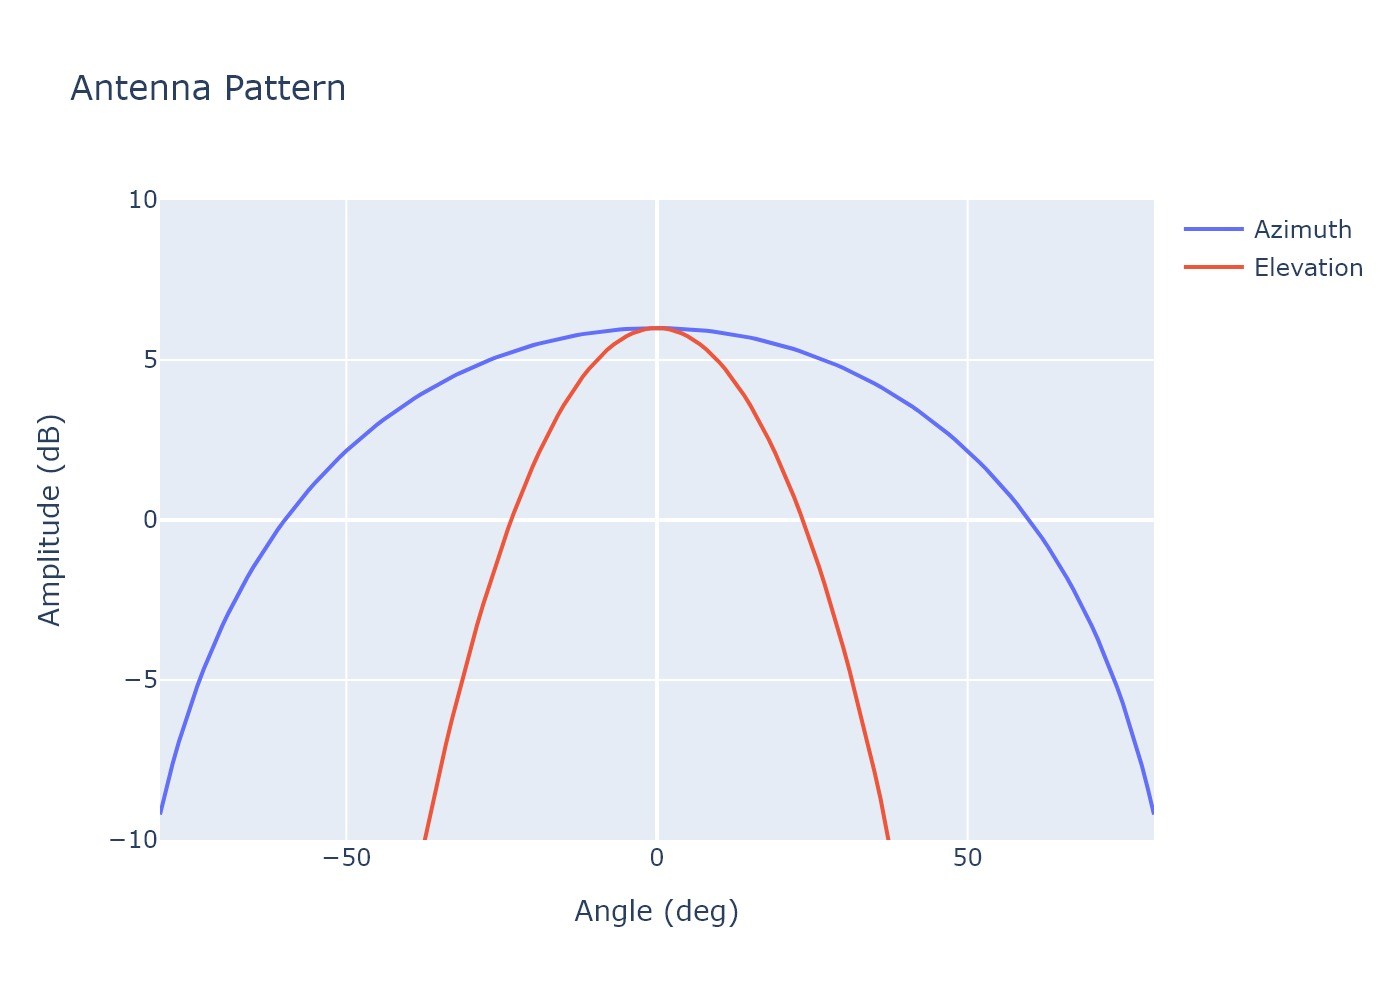

In [4]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=az_angle,
    y=az_pattern,
    name='Azimuth',
))
fig.add_trace(go.Scatter(
    x=el_angle,
    y=el_pattern,
    name='Elevation',
))

fig.update_layout(
    title='Antenna Pattern',
    yaxis=dict(title='Amplitude (dB)', range=[-10, 10]),
    xaxis=dict(title='Angle (deg)'),
)

# fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))
Image(fig.to_image(format="jpg", scale=2))


### Transmitter

Setup the basic transmitter parameters through `Transmitter` module.

The following table lists the parameters in this example.

 | Parameter                       | Variable in `Transmitter` | Value                |
 | ------------------------------- | ------------------------- | -------------------- |
 | Frequency ($f$)                 | `f`                       | [24.075, 24.175] GHz |
 | Time ($T$)                      | `t`                       | 80e-6 s              |
 | Transmitted power ($P_t$)       | `tx_power`                | 10 dBm               |
 | Pulse repetition period ($PRP$) | `prp`                     | 100 us               |
 | Number of pulses                | `pulses`                  | 256                  |

Here, `f` and `t` define the frequency modulation of the transmitter. The frequency changes from `24.075 GHz` to `24.175 GHz` within `80e-6 s`.

In [5]:
from radarsimpy import Radar, Transmitter, Receiver

tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

tx = Transmitter(f=[24.075e9, 24.175e9],
                 t=80e-6,
                 tx_power=10,
                 prp=100e-6,
                 pulses=256,
                 channels=[tx_channel])


### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `Receiver` | Value        |
 | -------------------------------- | ---------------------- | ------------ |
 | Sampling rate ($f_s$)            | `fs`                   | 2 Msps       |
 | Noise figure ($NF$)              | `noise_figure`         | 12 dB        |
 | RF gain/loss ($G_{rf}$)          | `rf_gain`              | 20 dB        |
 | Load resistor ($R_L$)            | `load_resistor`        | 500 $\Omega$ |
 | Baseband voltage gain ($G_{BB}$) | `baseband_gain`        | 30 dB        |


In [6]:
rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

rx = Receiver(fs=2e6,
              noise_figure=12,
              rf_gain=20,
              load_resistor=500,
              baseband_gain=30,
              channels=[rx_channel])


 Create the FMCW radar model based on all the parameters defined above.

In [7]:
radar = Radar(transmitter=tx, receiver=rx)


 Calculate the characteristics of the FMCW radar:

 - Maximum range (*with I/Q baseband*): $$R_{max}=\frac{c f_s T}{2B}$$

 - Maximum range (*without I/Q baseband*): $$R_{max}=\frac{c f_s T}{4B}$$

 - Unambiguous velocity: $$v_{ua}=\frac{c}{2 CRP \times f_c}$$ or $$v_{ua}=\pm \frac{c}{4 CRP \times f_c}$$

 - Range resolution: $$\delta_r=\frac{c}{2B}$$


### Targets

The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).

In [8]:
target_1 = dict(location=(200, 0, 0), speed=(-5, 0, 0), rcs=20, phase=0)
target_2 = dict(location=(95, 20, 0), speed=(-50, 0, 0), rcs=15, phase=0)
target_3 = dict(location=(30, -5, 0), speed=(-22, 0, 0), rcs=5, phase=0)

targets = [target_1, target_2, target_3]


## Simulate Baseband Signals
 
Use the `simulator` module to simulate the baseband samples. The user can choose between Python engine `simpy` or C++ engine `simc`.

The output baseband data is a 3-D matrix:

$[channels, pulses, ADC~samples]$

In [9]:
# Python engine
from radarsimpy.simulator import simpy
# C++ engine
from radarsimpy.simulator import simc

bb_data = simc(radar, targets, noise=True)
time_matrix = bb_data['timestamp']
data_matrix = bb_data['baseband']


Plot the baseband samples

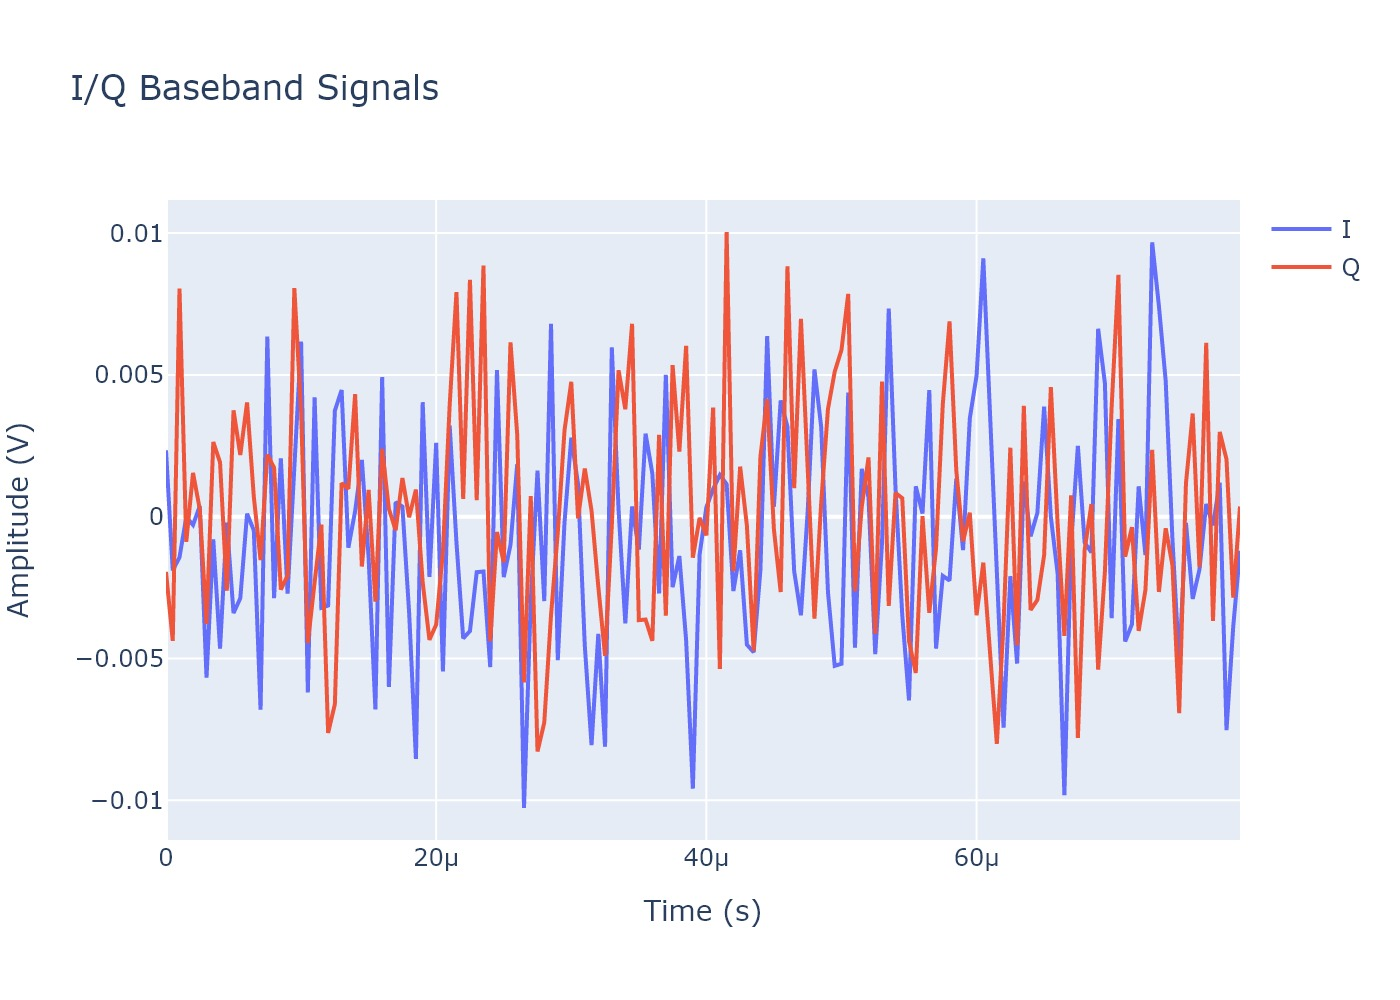

In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time_matrix[0, 0, :],
    y=np.real(data_matrix[0, 0, :]),
    name='I',
))
fig.add_trace(go.Scatter(
    x=time_matrix[0, 0, :],
    y=np.imag(data_matrix[0, 0, :]),
    name='Q',
))

fig.update_layout(
    title='I/Q Baseband Signals',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

# fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))
Image(fig.to_image(format="jpg", scale=2))


 ## Radar Signal Processing
 ### Range profile

In [11]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.range_fft(data_matrix, range_window)


C:\Users\zjx8rj\AppData\Local\Temp\ipykernel_5788\2809443318.py:4: DeprecationWarning:

Importing chebwin from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.chebwin' or the convenience function 'scipy.signal.get_window' instead.



Plot range profiles

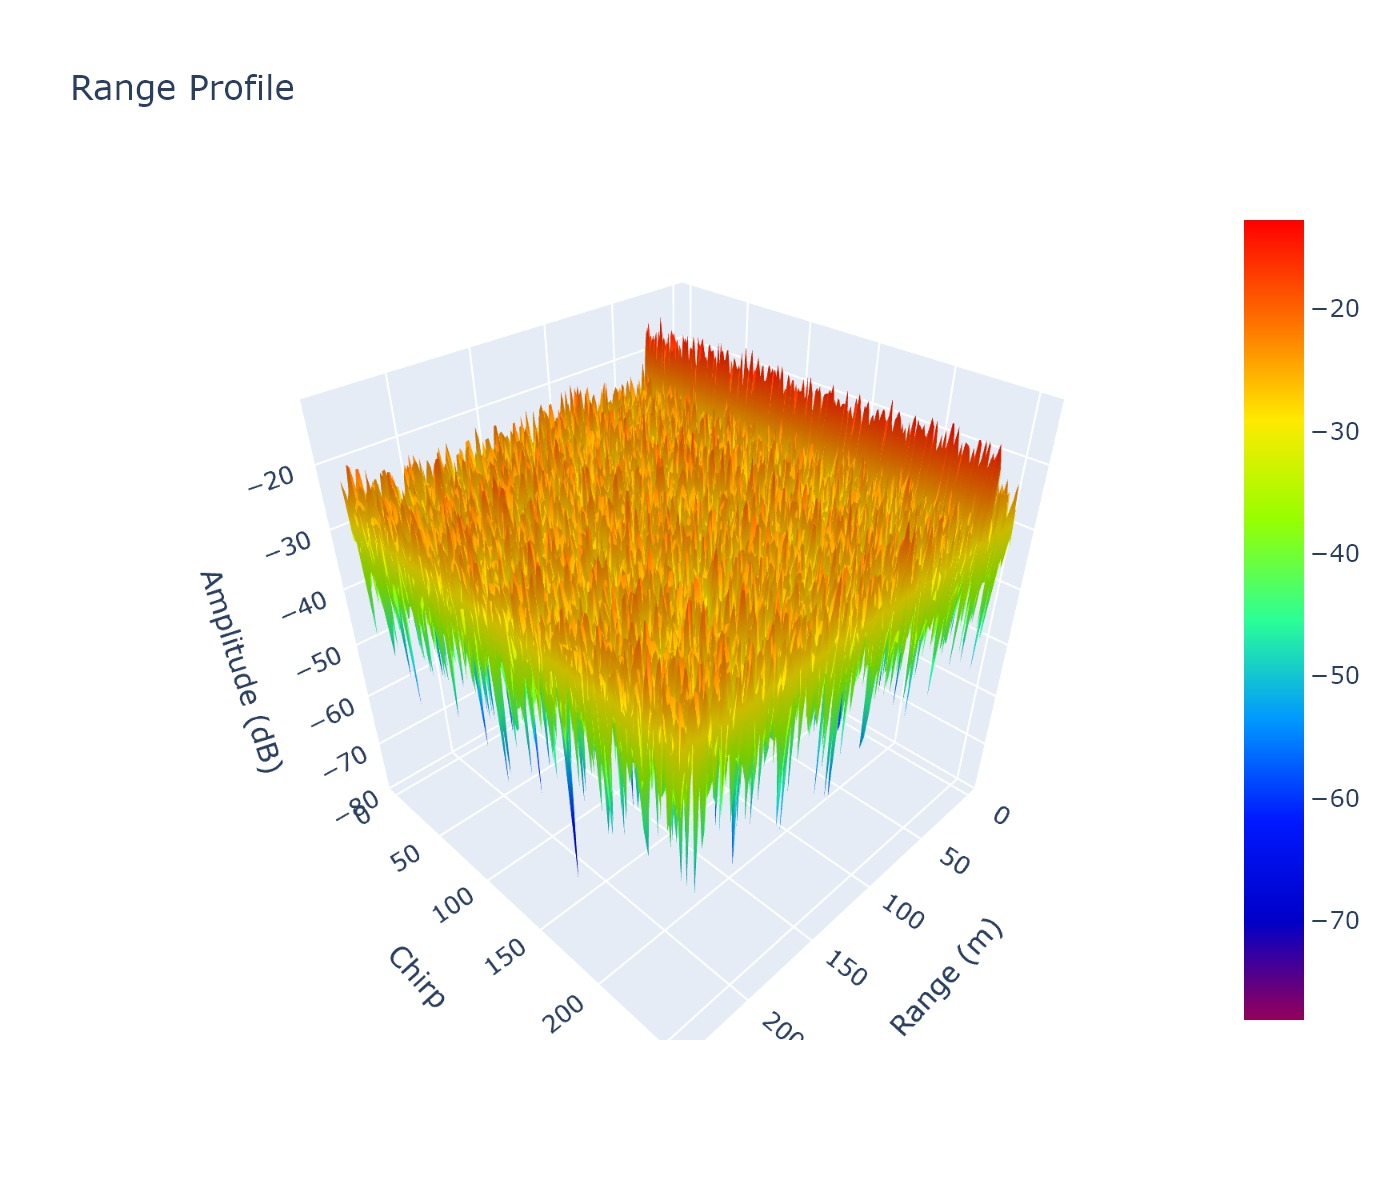

In [12]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)

range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    0, radar.transmitter.pulses, radar.transmitter.pulses, endpoint=False)

fig = go.Figure()

fig.add_trace(go.Surface(x=range_axis, y=doppler_axis, z=20 *
              np.log10(np.abs(range_profile[0, :, :])), colorscale='Rainbow'))

fig.update_layout(
    title='Range Profile',
    height=600,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Chirp'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
    ),
)

# fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))
Image(fig.to_image(format="jpg", scale=2))


 ### Range-Doppler processing

In [13]:
doppler_window = signal.chebwin(radar.transmitter.pulses, at=60)
range_doppler = proc.doppler_fft(range_profile, doppler_window)


C:\Users\zjx8rj\AppData\Local\Temp\ipykernel_5788\1755317144.py:1: DeprecationWarning:

Importing chebwin from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.chebwin' or the convenience function 'scipy.signal.get_window' instead.



Plot range-Doppler map

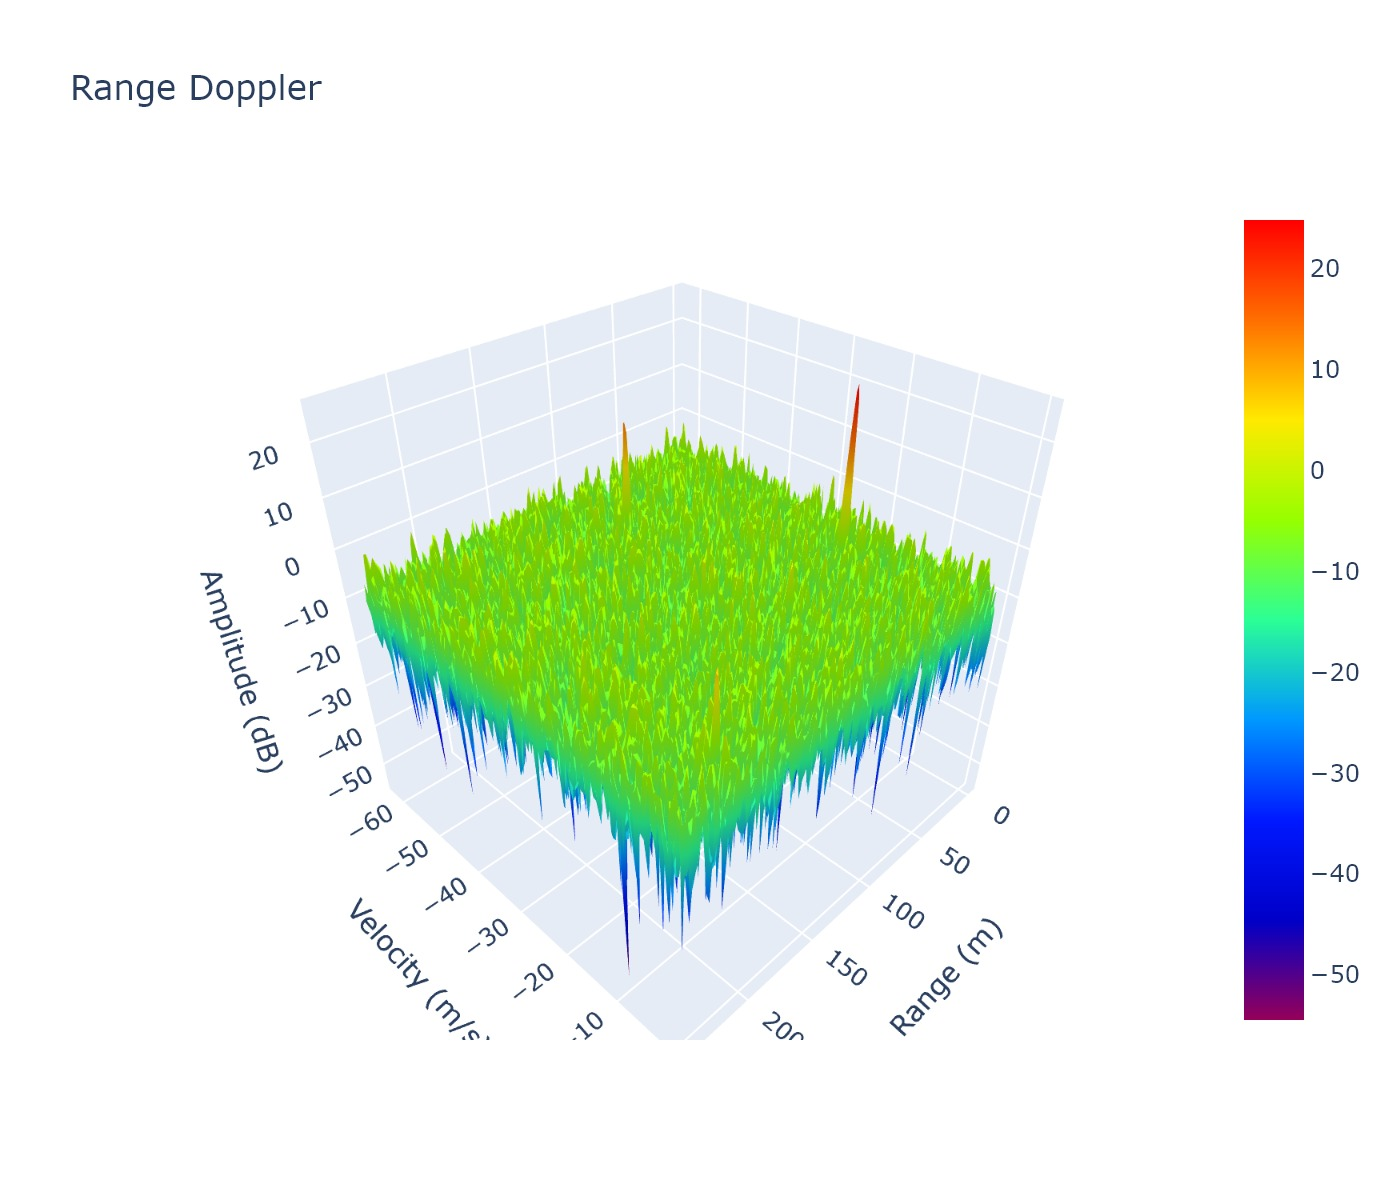

In [14]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
unambiguous_speed = 3e8 / radar.transmitter.prp[0] / \
    radar.transmitter.fc_vect[0] / 2

range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    -unambiguous_speed, 0, radar.transmitter.pulses, endpoint=False)

fig = go.Figure()
fig.add_trace(go.Surface(x=range_axis, y=doppler_axis, z=20 *
              np.log10(np.abs(range_doppler[0, :, :])), colorscale='Rainbow'))

fig.update_layout(
    title='Range Doppler',
    height=600,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Velocity (m/s)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
    ),
)

# fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))
Image(fig.to_image(format="jpg", scale=2))
